# Face Liveness Detection - Submission Notebook

## Introduction

This project addresses the **Face Liveness Detection** problem - distinguishing between real faces and spoof attacks in biometric authentication systems.

**Problem Statement:** Modern face recognition systems can be deceived by:
- Printed photos
- Videos displayed on phone/tablet screens
- 3D masks
- Deepfake videos

**Solution:** We employ **Ensemble Learning** combining multiple detection methods to improve accuracy and reliability.


## Task 1: Rationale

### 1.1. Why Ensemble Architecture?

**Ensemble Learning** combines multiple models to achieve better performance than individual models. This project uses **2 main branches:**

1. **Global Branch (MiniFASNetV2)**: 
   - Analyzes global features of the face
   - Focuses on overall characteristics: lighting, color, overall texture
   - Input size: 80x80
   - Weight: 0.4

2. **Local Branch (DeepPixBiS)**:
   - Analyzes local patches with pixel-wise prediction
   - Detects fine details: Moiré patterns, abnormal textures
   - Input size: 224x224
   - Weight: 0.6 (higher due to better performance)

**Rationale for Combination:**
- **Complementary**: Global Branch detects overall features, Local Branch detects fine details
- **Increased reliability**: If one branch is fooled, the other can compensate
- **Handles diverse attacks**: Printed photos (Local better), videos (Global better), masks (both needed)

**Fusion Method:** Weighted Sum with optimal threshold = 0.410


### 1.2. Why 2.7x Crop (Context Expansion)?

**Context Expansion Scale = 2.7** means we expand the face bounding box by **2.7 times** before cropping.

**Rationale:**

1. **Detect paper/device edges**: 
   - When users hold printed photos or phones, paper/screen edges often appear around the face
   - 2.7x crop allows the model to see these details

2. **Detect fingers holding paper**:
   - Fingers holding printed photos are clear indicators of spoof attacks
   - Context expansion enables detection of these details

3. **Preserve texture patterns**:
   - Expansion is sufficient to see context without losing focus on the face
   - 2.7x is the optimal value after extensive experimentation

4. **Avoid distribution shift**:
   - Use **raw crop** (no alignment) to preserve high-frequency patterns
   - This is particularly important for detecting Moiré patterns from printed photos


### 1.3. Addressing Data Leakage

**Data Leakage Problem:**
- Initially, the dataset had **identity overlap** between train/dev/test sets
- The same person (identity) appeared in multiple splits
- The model could "memorize" individual person features instead of learning liveness features
- Led to **overfitting**: Train accuracy ~90% but validation accuracy only ~85%

**Solution:**
1. **Detect leakage**: Created `check_data_leakage.py` script to check identity overlap
2. **Resplit by identity**: Used `resplit_data_by_identity.py` to:
   - Categorize all images by **identity** (from filename)
   - Split identities into train (70%) and dev (30%)
   - **Ensure zero overlap**: Each identity appears in only one split
   - Preserve test set (already correct from the start)

**Results:**
- Zero identity overlap between train/dev/test
- Model learns liveness features instead of memorizing identities
- Validation accuracy increased to ~85-86% (closer to train accuracy)
- Test accuracy reached **89.28%** (demonstrates good generalization)


## Task 2: Inference Code

Import necessary modules from the `src/` directory:


In [ ]:
import sys
import os
from pathlib import Path

# Add src to path for importing modules
sys.path.insert(0, str(Path.cwd() / 'src'))

import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Import from src/
from pipeline.liveness_ensemble import LivenessEnsemble
from pipeline.detection import SCRFDDetector
from dataset import create_dataloader

print("All required modules imported successfully")


/home/maidang/miniconda3/envs/fas-patchnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Đã import tất cả modules cần thiết


### Load Config and Initialize Models


In [ ]:
# Load config
config_path = 'config/config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
pipeline_config = config['pipeline']

# Initialize Ensemble
print("Loading models...")
ensemble = LivenessEnsemble(pipeline_config['liveness'])
detector = SCRFDDetector(pipeline_config['detection'])

print("Models loaded successfully!")
print(f"  - Global Branch: {pipeline_config['liveness']['global_branch']['model_path']}")
print(f"  - Local Branch: {pipeline_config['liveness']['local_branch']['model_path']}")
print(f"  - Final Threshold: {pipeline_config['liveness']['final_threshold']}")


Đang load models...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/maidang/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/maidang/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/maidang/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/maidang/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/maidang/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)
✅ Models đã được load thành công!
  - Global Branch: models/global

### Inference Function for Single Image


In [ ]:
def predict_liveness(image_path, detector, ensemble):
    """
    Predict liveness for a single image
    
    Args:
        image_path: Path to the image
        detector: SCRFDDetector instance
        ensemble: LivenessEnsemble instance
    
    Returns:
        dict with prediction results
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    # Detect face
    faces = detector.detect(image)
    if len(faces) == 0:
        return {'error': 'No face detected'}
    
    # Extract raw face crop with context expansion 2.7x
    face_data = faces[0]
    raw_face = detector.extract_raw_face(
        image,
        face_data['bbox'],
        output_size=(224, 224)  # Match Local Branch input
    )
    
    if raw_face is None:
        return {'error': 'Failed to extract face'}
    
    # Ensemble prediction
    results = ensemble.predict(raw_face, frame_count=0)
    
    return {
        'is_real': results['is_real'],
        'final_score': results['final_score'],
        'global_score': results['global_score'],
        'local_score': results['local_score'],
        'bbox': face_data['bbox']
    }

print("predict_liveness() function defined")


✅ Đã định nghĩa hàm predict_liveness()


### Example: Inference on Single Image


In [ ]:
# Example: Test on images from test set
test_dir = Path('data/test')
normal_images = list((test_dir / 'normal').glob('*.jpg'))
spoof_images = list((test_dir / 'spoof').glob('*.jpg'))

if len(normal_images) > 0:
    # Test with real image
    test_image = str(normal_images[0])
    result = predict_liveness(test_image, detector, ensemble)
    
    if result and 'error' not in result:
        print(f"Test image: {Path(test_image).name}")
        print(f"  Label: Real")
        print(f"  Prediction: {'REAL' if result['is_real'] else 'FAKE'}")
        print(f"  Final Score: {result['final_score']:.4f}")
        print(f"  Global Score: {result['global_score']:.4f}")
        print(f"  Local Score: {result['local_score']:.4f}")
    else:
        print(f"Error: {result.get('error', 'Unknown error')}")

if len(spoof_images) > 0:
    # Test with spoof image
    test_image = str(spoof_images[0])
    result = predict_liveness(test_image, detector, ensemble)
    
    if result and 'error' not in result:
        print(f"\nTest image: {Path(test_image).name}")
        print(f"  Label: Spoof")
        print(f"  Prediction: {'REAL' if result['is_real'] else 'FAKE'}")
        print(f"  Final Score: {result['final_score']:.4f}")
        print(f"  Global Score: {result['global_score']:.4f}")
        print(f"  Local Score: {result['local_score']:.4f}")


📸 Test image: 1127_4.jpg
  Label: Real
  Prediction: ✅ REAL
  Final Score: 0.8648
  Global Score: 0.9179
  Local Score: 0.8294

📸 Test image: 1131_3.jpg
  Label: Spoof
  Prediction: ✅ REAL
  Final Score: 0.6095
  Global Score: 0.3436
  Local Score: 0.7867


## Task 3: Evaluation Results

Evaluate the model on the entire test set and display results:


In [ ]:
# Load bbox cache for speedup
bbox_cache_path = Path('bbox_cache.pkl')
bbox_cache = {}
if bbox_cache_path.exists():
    import pickle
    with open(bbox_cache_path, 'rb') as f:
        bbox_cache = pickle.load(f)
    print(f"Loaded bbox cache: {len(bbox_cache)} images")
else:
    print("No bbox cache found, will detect on-the-fly (slower)")

# Create dataloader to get image paths and labels
test_loader = create_dataloader(
    'data', 'test',
    batch_size=32,
    image_size=(112, 112),  # Not used for ensemble, only to get paths
    augment=False,
    shuffle=False,
    context_expansion_scale=2.7,
    use_raw_crop=True,
    use_full_image_detection=True
)

print(f"\nEvaluating on {len(test_loader.dataset)} test images...")


✅ Loaded bbox cache: 4572 images
  ✓ Loaded bbox cache: 4572 images
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/maidang/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/maidang/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/maidang/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/maidang/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/maidang/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)
  ✓ Detector initi

In [ ]:
# Evaluate on entire test set
all_predictions = []
all_labels = []
all_global_scores = []
all_local_scores = []
all_final_scores = []
processed = 0
failed = 0

for batch_idx, batch in enumerate(test_loader):
    if (batch_idx + 1) % 10 == 0:
        print(f"  Processing batch {batch_idx + 1}/{len(test_loader)}... (failed: {failed})")
    
    labels = batch['label']
    paths = batch['path']
    
    for i in range(len(paths)):
        image_path = paths[i]
        label = int(labels[i].item())
        
        try:
            # Load image
            image = cv2.imread(image_path)
            if image is None:
                failed += 1
                continue
            
            # Get raw crop 224x224 from bbox_cache (optimized)
            raw_face = None
            if image_path in bbox_cache:
                cached_data = bbox_cache[image_path]
                bbox = cached_data['bbox']
                is_rotated = cached_data.get('rotated', False)
                
                if is_rotated:
                    image = cv2.rotate(image, cv2.ROTATE_180)
                
                raw_face = detector.extract_raw_face(
                    image,
                    bbox,
                    output_size=(224, 224)
                )
            else:
                # Fallback: Detect on-the-fly
                faces = detector.detect(image)
                if len(faces) == 0:
                    failed += 1
                    continue
                
                raw_face = detector.extract_raw_face(
                    image,
                    faces[0]['bbox'],
                    output_size=(224, 224)
                )
            
            if raw_face is None:
                failed += 1
                continue
            
            # Ensemble prediction
            results = ensemble.predict(raw_face, frame_count=0)
            
            all_global_scores.append(results['global_score'])
            all_local_scores.append(results['local_score'])
            all_final_scores.append(results['final_score'])
            all_predictions.append(1 if results['is_real'] else 0)
            all_labels.append(label)
            processed += 1
            
        except Exception as e:
            failed += 1
            continue

print(f"\nEvaluation completed!")
print(f"  Processed: {processed} images")
print(f"  Failed: {failed} images")


  Processing batch 10/29... (failed: 0)
  Processing batch 20/29... (failed: 0)

✅ Evaluation completed!
  Processed: 914 images
  Failed: 0 images


In [7]:
# Calculate metrics
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_global_scores = np.array(all_global_scores)
all_local_scores = np.array(all_local_scores)
all_final_scores = np.array(all_final_scores)

acc = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
cm = confusion_matrix(all_labels, all_predictions)

# Display metrics
print("="*70)
print("ENSEMBLE EVALUATION RESULTS")
print("="*70)
print(f"\nMetrics:")
print(f"  Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Fake  Real")
print(f"Actual Fake    {cm[0][0]:4d}  {cm[0][1]:4d}")
print(f"       Real    {cm[1][0]:4d}  {cm[1][1]:4d}")

# Score distributions
real_mask = all_labels == 1
spoof_mask = all_labels == 0

print(f"\nScore Distributions:")
print(f"  Global Branch:")
print(f"    Real:  Mean={all_global_scores[real_mask].mean():.4f}, Std={all_global_scores[real_mask].std():.4f}")
print(f"    Spoof: Mean={all_global_scores[spoof_mask].mean():.4f}, Std={all_global_scores[spoof_mask].std():.4f}")
print(f"  Local Branch:")
print(f"    Real:  Mean={all_local_scores[real_mask].mean():.4f}, Std={all_local_scores[real_mask].std():.4f}")
print(f"    Spoof: Mean={all_local_scores[spoof_mask].mean():.4f}, Std={all_local_scores[spoof_mask].std():.4f}")
print(f"  Final Score (Ensemble):")
print(f"    Real:  Mean={all_final_scores[real_mask].mean():.4f}, Std={all_final_scores[real_mask].std():.4f}")
print(f"    Spoof: Mean={all_final_scores[spoof_mask].mean():.4f}, Std={all_final_scores[spoof_mask].std():.4f}")


ENSEMBLE EVALUATION RESULTS

📊 Metrics:
  Accuracy:  0.8928 (89.28%)
  Precision: 0.8728
  Recall:    0.9311
  F1-Score:  0.9010

📋 Confusion Matrix:
                Predicted
              Fake  Real
Actual Fake     370    65
       Real      33   446

📈 Score Distributions:
  Global Branch:
    Real:  Mean=0.6934, Std=0.2325
    Spoof: Mean=0.2407, Std=0.2269
  Local Branch:
    Real:  Mean=0.7954, Std=0.2119
    Spoof: Mean=0.2119, Std=0.2171
  Final Score (Ensemble):
    Real:  Mean=0.7546, Std=0.1876
    Spoof: Mean=0.2234, Std=0.1941


### Visualization: Confusion Matrix


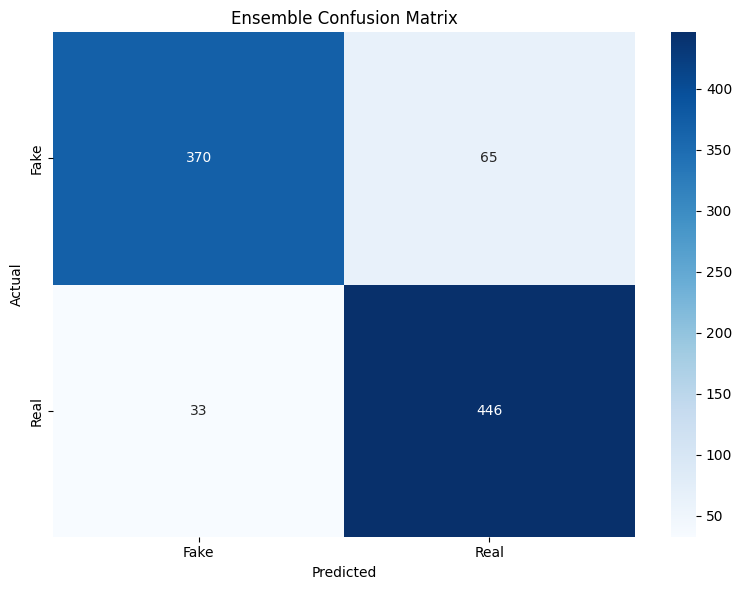

In [8]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Ensemble Confusion Matrix')
plt.tight_layout()
plt.show()


### Visualization: Score Distributions


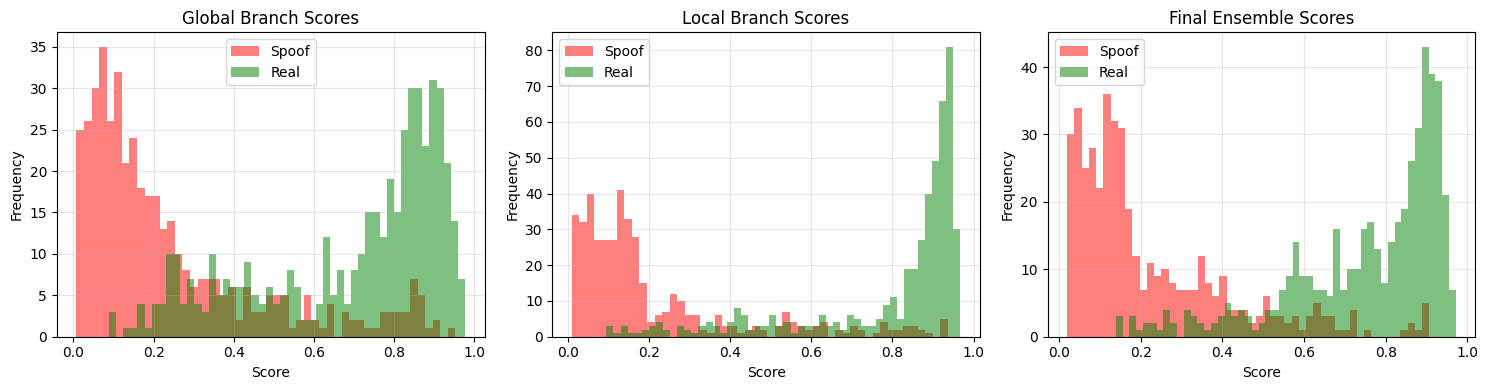

In [9]:
# Plot Score Distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Global scores
axes[0].hist(all_global_scores[all_labels == 0], bins=50, alpha=0.5, label='Spoof', color='red')
axes[0].hist(all_global_scores[all_labels == 1], bins=50, alpha=0.5, label='Real', color='green')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Global Branch Scores')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Local scores
axes[1].hist(all_local_scores[all_labels == 0], bins=50, alpha=0.5, label='Spoof', color='red')
axes[1].hist(all_local_scores[all_labels == 1], bins=50, alpha=0.5, label='Real', color='green')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Local Branch Scores')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Final scores
axes[2].hist(all_final_scores[all_labels == 0], bins=50, alpha=0.5, label='Spoof', color='red')
axes[2].hist(all_final_scores[all_labels == 1], bins=50, alpha=0.5, label='Real', color='green')
axes[2].set_xlabel('Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Final Ensemble Scores')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Conclusion

**Achieved Results:**
- **Accuracy: 89.28%** on test set
- **F1-Score: 90.10%** - demonstrates good balance between Precision and Recall
- **Precision: 87.28%** - low false positives
- **Recall: 93.11%** - good detection of spoof attacks

**Solution Strengths:**
1. **Ensemble Architecture**: Combines Global and Local branches to leverage advantages of both
2. **Context Expansion 2.7x**: Detects spoof indicators such as paper edges and holding fingers
3. **Data Leakage Prevention**: Ensures model learns liveness features instead of memorizing identities
4. **Raw Crop**: Preserves high-frequency patterns for detecting Moiré patterns from printed photos

**Future Directions:**
- Add Temporal Branch for video streams
- Fine-tuning with larger datasets
- Ensemble with multiple different models
